# Stock Price Prediction Project using TensorFlow

## Importing Libraries and Dataset

In [74]:
import os
#os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from datetime import datetime 
import mplcursors as mpc

## Now let’s load the dataset into the pandas dataframe. 



In [75]:
data = pd.read_csv('data/TATASTEEL.NS2.csv')
print(data.shape) 
print(data.sample(7)) 

(1838, 7)
            date        open        high         low       close   adj close  \
1260  2022-02-15  119.684998  121.199997  115.154999  120.775002  108.778175   
1282  2022-03-21  130.800003  133.399994  129.449997  130.294998  117.352531   
293   2018-03-16   61.174999   61.389999   59.439999   60.020000   49.346516   
423   2018-09-25   60.900002   60.900002   57.500000   60.099998   50.292923   
446   2018-10-30   57.125000   57.200001   56.310001   56.450001   47.238529   
18    2017-02-06   45.197826   45.502701   44.697639   45.102551   36.432678   
745   2020-01-21   48.779999   48.779999   47.349998   47.615002   40.886814   

         volume  
1260  101889210  
1282   84227630  
293   117395820  
423   109856240  
446    40153190  
18     50453281  
745   113158030  


In [76]:
data.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838 entries, 0 to 1837
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1838 non-null   object 
 1   open       1838 non-null   float64
 2   high       1838 non-null   float64
 3   low        1838 non-null   float64
 4   close      1838 non-null   float64
 5   adj close  1838 non-null   float64
 6   volume     1838 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 100.6+ KB


Whenever we deal with the date or time feature, it should always be in the DateTime data type. Pandas library helps us convert the object date feature to the DateTime data type.

In [77]:
data['date'] = pd.to_datetime(data['date']) 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838 entries, 0 to 1837
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1838 non-null   datetime64[ns]
 1   open       1838 non-null   float64       
 2   high       1838 non-null   float64       
 3   low        1838 non-null   float64       
 4   close      1838 non-null   float64       
 5   adj close  1838 non-null   float64       
 6   volume     1838 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 100.6 KB


visualize the distribution of open and closed Stock prices through 5 years. 

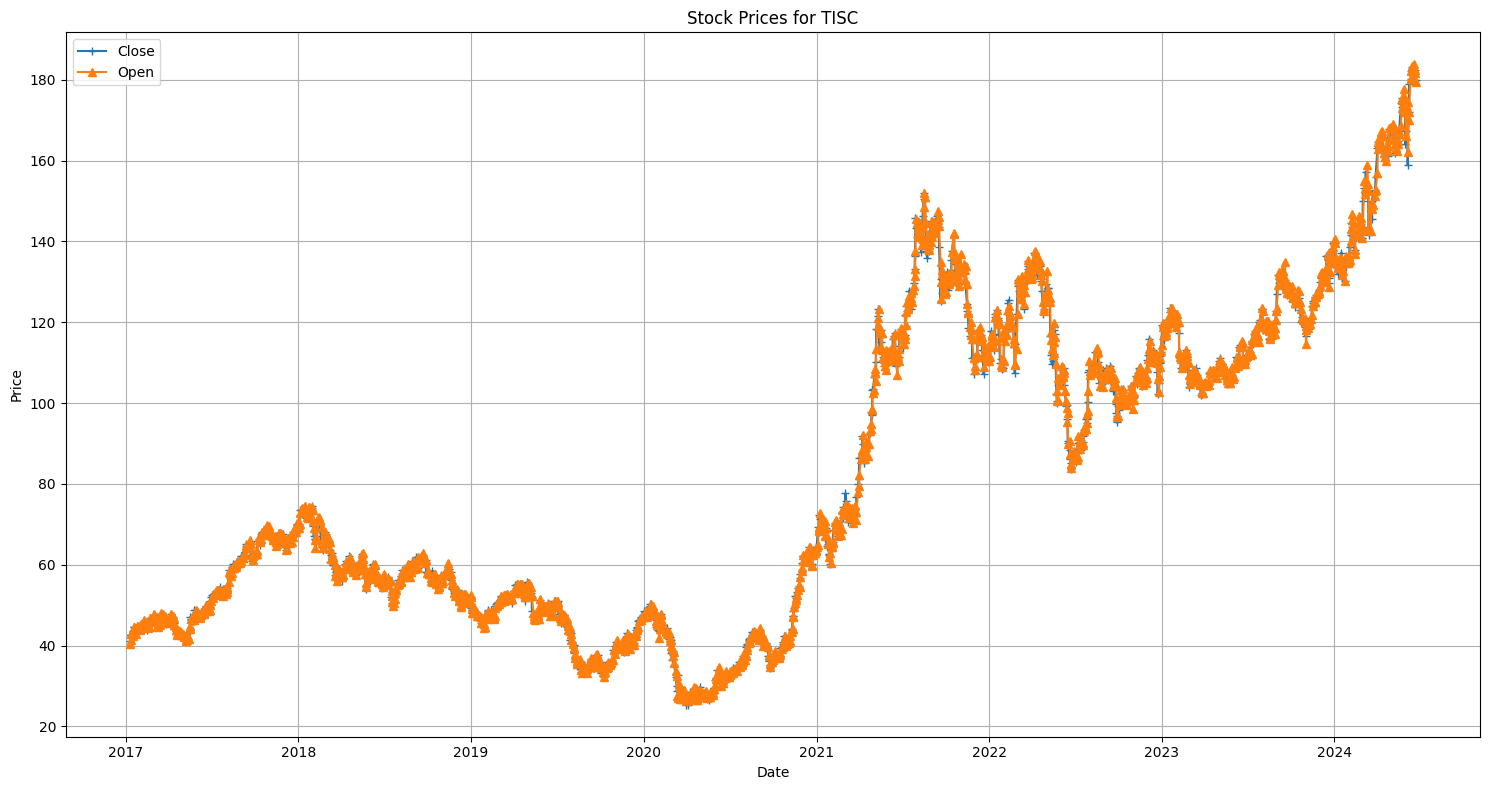

In [78]:
plt.figure(figsize=(15, 8)) 
plt.plot(data['date'], data['close'], data="r", label="Close", marker="+")
plt.plot(data['date'], data['open'], data="g", label="Open", marker="^")
plt.title(f"Stock Prices for TISC")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Now let’s plot the volume of trade as a function of time.

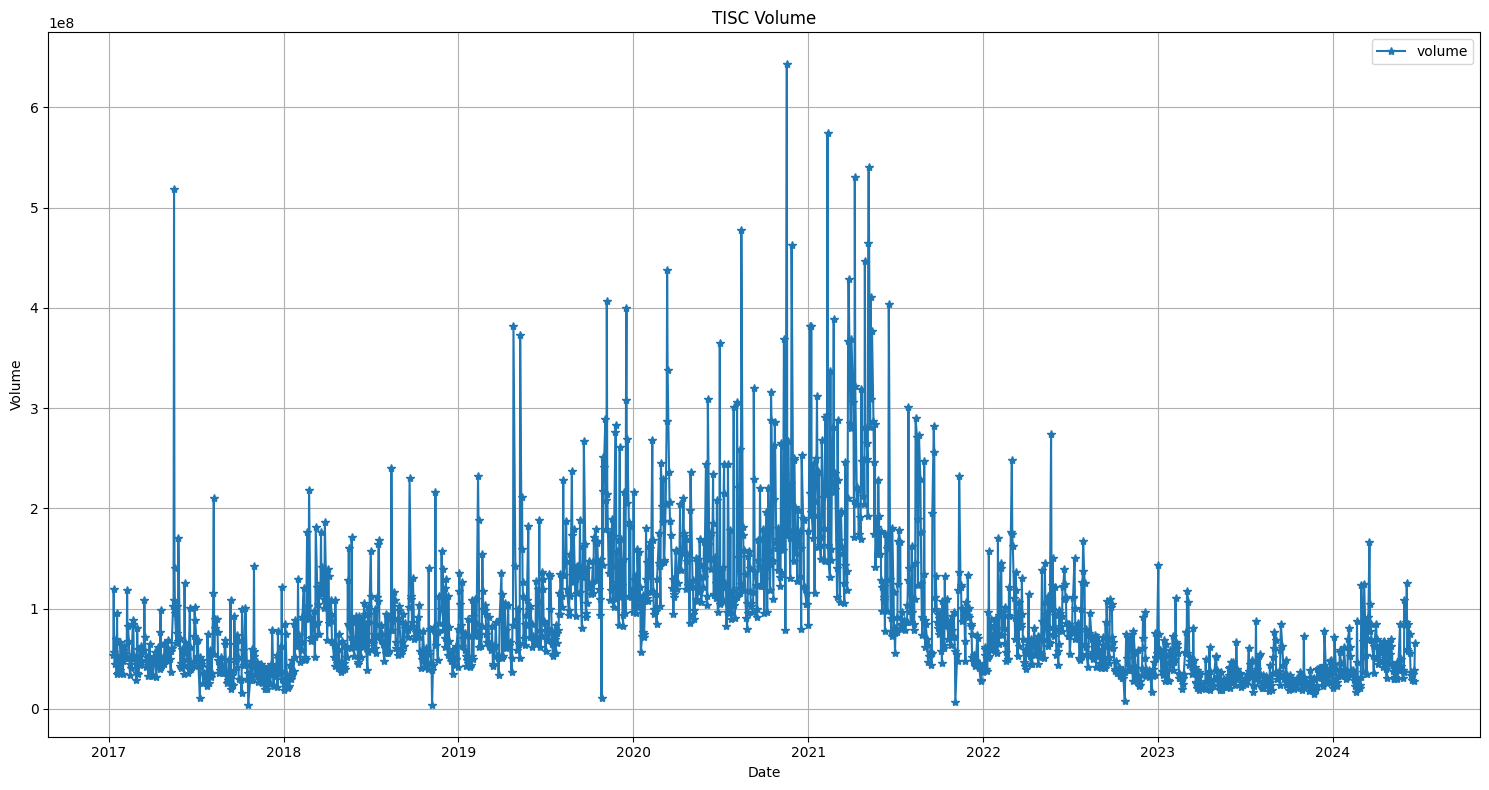

In [79]:
plt.figure(figsize=(15, 8)) 
plt.plot(data['date'], data['volume'], data="purple", marker="*")
plt.title("TISC Volume")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

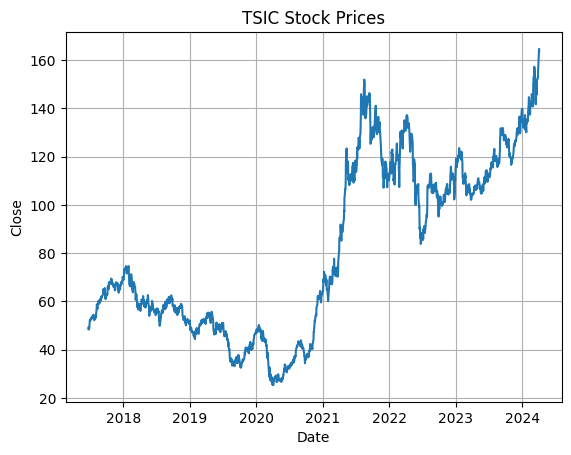

In [80]:
prediction_range = data.loc[(data['date'] > datetime(2017,6,21)) 
 & (data['date']<datetime(2024,4,4))] 
plt.plot(prediction_range['date'],prediction_range['close']) 
plt.xlabel("Date") 
plt.ylabel("Close") 
plt.title("TSIC Stock Prices") 
plt.grid(True) 
plt.show()

In [81]:
close_data = prediction_range.filter(['close']) 
dataset = close_data.values 
print(dataset.shape)
training = int(np.ceil(len(dataset) * .95)) 
print(training) 


(1675, 1)
1592


Now we have the training data length, next applying scaling and preparing features and labels that are x_train and y_train.

In [82]:
from sklearn.preprocessing import MinMaxScaler 
  
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset) 
  
train_data = scaled_data[0:int(training), :] 
print(train_data.shape) 
# prepare feature and labels 
x_train = [] 
y_train = [] 
  
for i in range(60, len(train_data)): 
    x_train.append(train_data[i-60:i, 0]) 
    y_train.append(train_data[i, 0]) 
  
x_train, y_train = np.array(x_train), np.array(y_train) 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 

(1592, 1)


Above we perform a reshape operation on x_train to make it 3D. 

Why This Reshape is Necessary:
RNNs and LSTMs require input data to be 3D to understand the temporal structure of the data.
By reshaping x_train to (samples, time steps, features), you ensure the model can process each sample correctly, considering the sequence of 60 time steps and the single feature (closing price) at each time step.

x_train before reshaping looks like:
Shape: (1000, 60) (1000 samples, each with 60 time steps).

x_train after reshaping looks like:
Shape: (1000, 60, 1) (1000 samples, each with 60 time steps and 1 feature).

Using TensorFlow, we can easily create LSTM-gated RNN cells. LSTM is used in Recurrent Neural Networks for sequence models and time series data. LSTM is used to avoid the vanishing gradient issue which is widely occurred in training RNN. To stack multiple LSTM in TensorFlow it is mandatory to use return_sequences = True. Since our data is time series varying we apply no activation to the output layer and it remains as 1 node. 

In [83]:
model = keras.models.Sequential() 
print(x_train.shape) 
model.add(Input(shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64, 
                            return_sequences=True)) 
model.add(keras.layers.LSTM(units=64)) 
model.add(keras.layers.Dense(32)) 
model.add(keras.layers.Dropout(0.5)) 
model.add(keras.layers.Dense(1)) 
model.summary()

(1532, 60, 1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Model Compilation and Training
While compiling a model we provide these three essential parameters:

optimizer – This is the method that helps to optimize the cost function by using gradient descent.
loss – The loss function by which we monitor whether the model is improving with training or not.
metrics – This helps to evaluate the model by predicting the training and the validation data.

In [84]:
model.compile(optimizer='adam', 
              loss='mean_squared_error') 
history = model.fit(x_train, 
                    y_train, 
                    epochs=10) 

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0799
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0108
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0083
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0078
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0076
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0069
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0060
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0061
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0055
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0062


above

x_train is the input data for training. It should be a 3D array with shape (num_samples, num_timesteps, num_features), where:
num_samples is the number of training samples.
num_timesteps is the number of time steps per sample (60 in your case).
num_features is the number of features per time step (1 in your case).
y_train is the target data for training. It should be a 1D or 2D array with the actual values you want to predict.

Now

For predicting we require testing data, so we first create the testing data and then proceed with the model prediction. 

In [85]:
test_data = scaled_data[training - 60:, :] 
x_test = [] 
y_test = dataset[training:, :] 
for i in range(60, len(test_data)): 
    x_test.append(test_data[i-60:i, 0]) 
  
x_test = np.array(x_test) 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
  
# predict the testing data 
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions) 
  
# evaluation metrics 
mse = np.mean(((predictions - y_test) ** 2)) 
print("MSE", mse) 
print("RMSE", np.sqrt(mse)) 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
MSE 42.92086987744337
RMSE 6.551402130646796


Now that we have predicted the testing data, let us visualize the final results. 

C:\Users\shaji\AppData\Local\Temp\ipykernel_7432\3431790827.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


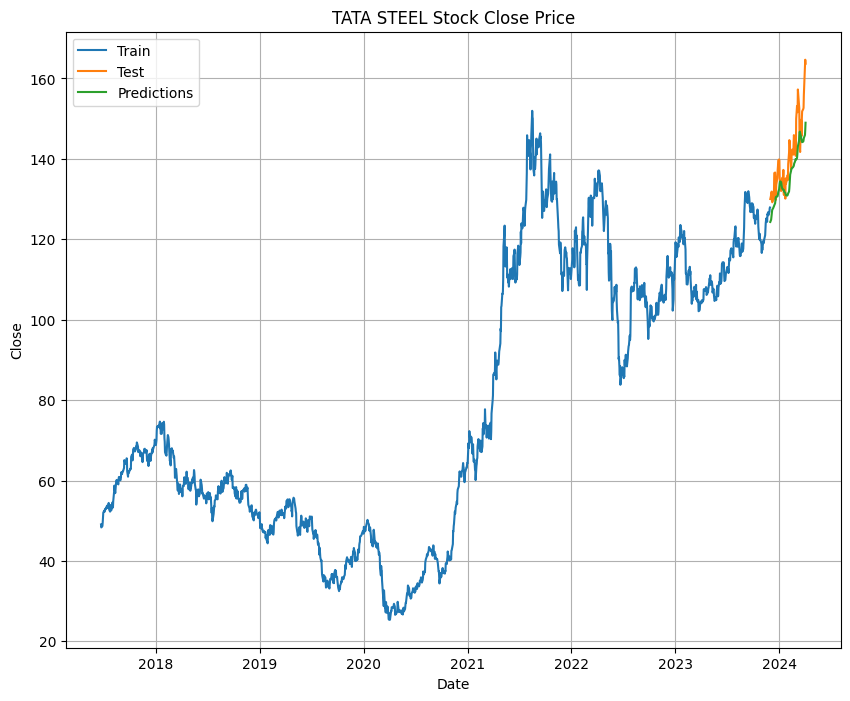

In [86]:
train = prediction_range[:training] 
test = prediction_range[training:] 
test['Predictions'] = predictions 
  
plt.figure(figsize=(10, 8)) 
plt.plot(train['date'], train['close']) 
plt.plot(test['date'], test[['close', 'Predictions']]) 
plt.title('TATA STEEL Stock Close Price') 
plt.xlabel('Date') 
plt.ylabel("Close") 
plt.grid(True) 
plt.legend(['Train', 'Test', 'Predictions']) 
mpc.cursor(hover=True)
plt.show() 